In [1]:
import torch
from torchvision.models import alexnet
from torchsummary import summary
from utils import classify
import numpy as np
from matplotlib import pyplot as plt
import os
from male import get_important_neurons, get_positions, associate_channels
import openai
from json import loads

In [2]:
%load_ext autoreload

In [3]:
filename = 'czapi.jpg'

In [4]:
model = alexnet(pretrained=True)
_ = model.eval()
# summary(model, (3, 224, 224))

In [5]:
%autoreload 2
probabilities, top_probabilities, categories, input_batch, input_tensor = classify(filename, model)

In [6]:
image_center_resized = input_tensor.numpy()
image_center_resized = np.transpose(image_center_resized, (1, 2, 0))
if not os.path.exists(os.path.join('images', 'clipped', filename)):
    plt.imsave(os.path.join('images', 'clipped', filename), image_center_resized)

In [7]:
import pandas as pd
import os
descriptions = pd.read_csv(os.path.join('milan_results', 'alexnet_imagenet.csv'))
#layer_names = ['conv1'] + ['layer' + str(i) for i in range(1, 5, 1)]
layer_names = ['conv5']
layer_map = {'conv1' : model.features[0], 
             'conv2' : model.features[3], 
             'conv3' : model.features[6], 
             'conv4' : model.features[8], 
             'conv5' : model.features[10]}

In [8]:
per_layer_results, per_layer_activations = get_important_neurons(10, 
                                                                 input_batch, 
                                                                 model, 
                                                                 layer_names, 
                                                                 layer_map, 
                                                                 descriptions, 
                                                                 probabilities)

/home/adamwsl/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [9]:
per_layer_positions = get_positions(per_layer_results, per_layer_activations)

In [10]:
prompt = str(categories[0]) + ', '
tmp = []
positions = per_layer_positions['conv5']
results = per_layer_results['conv5']
for k, v in positions.items():
    tmp.append({'description' : results[k], 'positions' : [], 'id' : k})
    if len(v) <= 3:
        tmp[-1]['positions'] = v
prompt += str(tmp)
print(prompt)

Great Dane, [{'description': 'Dogs and guinea pig', 'positions': [], 'id': 125}, {'description': 'Dog heads', 'positions': [], 'id': 30}, {'description': 'Animal legs', 'positions': [], 'id': 214}, {'description': 'Animal heads', 'positions': [], 'id': 87}, {'description': 'Rounded edges in pictures', 'positions': [], 'id': 209}, {'description': 'Dog heads', 'positions': ['right', 'bottom'], 'id': 66}, {'description': 'Animal heads', 'positions': ['top', 'center'], 'id': 235}, {'description': 'Animal heads', 'positions': ['left', 'top', 'bottom'], 'id': 254}, {'description': 'Dog heads', 'positions': ['right', 'top'], 'id': 230}, {'description': 'Dog ears', 'positions': ['right', 'top', 'bottom'], 'id': 61}]


In [11]:
with open('/home/adamwsl/.gpt_api_token/token.txt', 'r') as f:
    token = f.readline().strip()
with open('prompts/system_prompt.txt', 'r') as f:
    system_prompt = f.readline()
with open('prompts/example_prompt_1.txt', 'r') as f:
    example_prompt_1 = f.readline()
with open('prompts/example_output_1.txt', 'r') as f:
    example_output_1 = f.readline()
full_prompt = 'PROMPT: "' + prompt + '"'
print(full_prompt)

PROMPT: "Great Dane, [{'description': 'Dogs and guinea pig', 'positions': [], 'id': 125}, {'description': 'Dog heads', 'positions': [], 'id': 30}, {'description': 'Animal legs', 'positions': [], 'id': 214}, {'description': 'Animal heads', 'positions': [], 'id': 87}, {'description': 'Rounded edges in pictures', 'positions': [], 'id': 209}, {'description': 'Dog heads', 'positions': ['right', 'bottom'], 'id': 66}, {'description': 'Animal heads', 'positions': ['top', 'center'], 'id': 235}, {'description': 'Animal heads', 'positions': ['left', 'top', 'bottom'], 'id': 254}, {'description': 'Dog heads', 'positions': ['right', 'top'], 'id': 230}, {'description': 'Dog ears', 'positions': ['right', 'top', 'bottom'], 'id': 61}]"


In [12]:
with open('prompts/full_prompt.txt', 'r') as f:
    whole_prompt = f.readlines()
whole_prompt = ''.join(whole_prompt)
full_prompt = whole_prompt + 'PROMPT: "' + prompt + '"'
print(full_prompt)

You are tasked with a problem of creating a deep convolutional network classification EXPLANATION. You will be given an python object in form of `chosen class, [{'neuron description' : *neuron description*, 'neuron positions' : *neuron positions*, neuron id' : *neuron id *}, {'neuron description' : *neuron description*, 'neuron positions' : *neuron positions*, 'neuron id' : *neuron id *}, …]` where `...` means that there might be numerous triplets more, and  which is a class that model has picked. I want you to do two things:
1. create a grammatically correct sentence which will explain the model's decision.
2. Decide which neuron descriptions do not fit with `chosen class` and do not include those neuron descriptions in the final explanation. What I mean by 'do not fit' is that they are completely unrelated with chosen class (like 'dentist' and 'animal heads'). Do include in final explanation neuron descriptions which aren't directly related to chosen class, but they may be indirectly

In [13]:
API_KEY = token
openai.api_key = API_KEY
response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "user", "content": full_prompt},
    ]
)

In [20]:
print(response["choices"][0]["message"]["content"])

KeyError: 'message'

In [16]:
x = associate_channels(input_batch=input_batch, 
                       prev_layer=layer_map['conv4'], 
                       prev_out_channels=256,
                       curr_layer=layer_map['conv5'], 
                       target_ch_id=232, 
                       model=model)
print(tops := list(torch.argsort(x).numpy())[:10])

[54, 187, 170, 166, 227, 242, 218, 9, 75, 119]


In [17]:
query = descriptions[descriptions['layer'] == 'conv4']
tops = list(torch.argsort(x).numpy())[:5]
print(tops)
query =  query[query['unit'].isin(tops)]
query.set_index('unit', inplace=True)
query = query.loc[tops]
query.reset_index(inplace=True)
query

[54, 187, 170, 166, 227]


,unit,layer,description
0,54,conv4,Vertical lines
1,187,conv4,Grids
2,170,conv4,Stripes
3,166,conv4,Red and white objects
4,227,conv4,White backgrounds


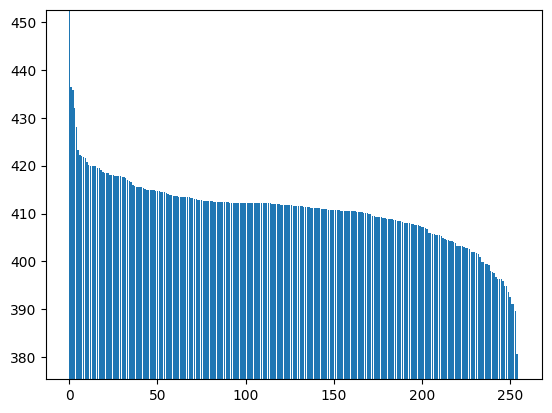

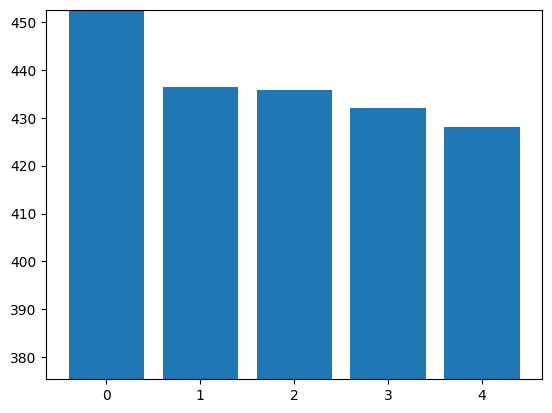

In [18]:
y = list(x)
y.sort(reverse=True)
plt.ylim(min(y), max(y))
plt.bar(range(len(y)), y)
plt.show()
plt.ylim(min(y), max(y))
plt.bar(range(len(y[:5])), y[:5])
plt.show()